### GPflow

In [1]:
from utils import *

In [2]:
data = np.loadtxt('data/DataTrn.txt')
labels_ = np.loadtxt("data/DataTrnLbls.txt")
Y = data

In [3]:
Q = 5
M = 20  # number of inducing pts
N = Y.shape[0]
X_mean = gpflow.models.PCA_reduce(Y, Q) # Initialise via PCA
Z = np.random.permutation(X_mean.copy())[:M]

fHmmm = False
if(fHmmm):
    k = (kernels.RBF(3, ARD=True, active_dims=slice(0,3)) +
         kernels.Linear(2, ARD=False, active_dims=slice(3,5)))
else:
    k = (kernels.RBF(3, ARD=True, active_dims=[0,1,2]) +
         kernels.Linear(2, ARD=False, active_dims=[3, 4]))

m = gpflow.models.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
                                kern=k, M=M, Z=Z)
m.likelihood.variance = 0.01

opt = gpflow.train.ScipyOptimizer()
m.compile()
opt.minimize(m, maxiter=gpflow.test_util.notebook_niter(10000))

/home/arnav/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -5535.574334
  Number of iterations: 1663
  Number of functions evaluations: 1767


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -5535.574334
  Number of iterations: 1663
  Number of functions evaluations: 1767


In [4]:
m.kern.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
BayesianGPLVM/kern/kernels/0/lengthscales,Parameter,None,+ve,True,"(3,)",True,"[5.717519832562978, 69.94117024188954, 1.61438..."
BayesianGPLVM/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,21.638272060813293
BayesianGPLVM/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,0.027213507953804825


In [5]:
kern = m.kern.kernels[0]
sens = np.sqrt(kern.variance.read_value())/kern.lengthscales.read_value()
print(sens)

[0.81358627 0.06650869 2.88141104]


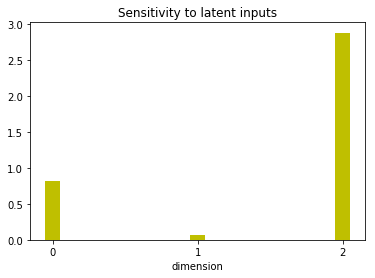

In [6]:
fig, ax = plt.subplots()
dims = np.arange(len(sens))
ax.bar(dims, sens, 0.1, color='y')
ax.set_xticks(dims)
ax.set_xlabel('dimension')
ax.set_title('Sensitivity to latent inputs');

In [7]:
dim1, dim2 = sens.argsort()[::-1][:2]  # the two dimensions with highest sensitivity

In [3]:
labels = [l.argmax() for l in labels_]

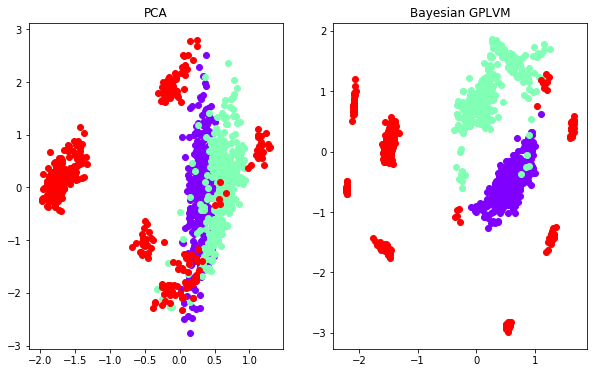

In [9]:
XPCAplot = gpflow.models.PCA_reduce(Y, 2)
GPLVM_X_mean = m.X_mean.read_value()

f, ax = plt.subplots(1,2, figsize=(10,6))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))

for i, c in zip(np.unique(labels), colors):
    ax[0].scatter(XPCAplot[labels==i, 0], XPCAplot[labels==i, 1], color=c, label=i)
    ax[0].set_title('PCA')
    ax[1].scatter(GPLVM_X_mean[labels==i, dim1], GPLVM_X_mean[labels==i, dim2], color=c, label=i)
    ax[1].set_title('Bayesian GPLVM')
plt.savefig("oil_pca_rep.png")

In [11]:
# reconstruction error based only on the mean predictions
((m.predict_y(GPLVM_X_mean[:,:])[0] - Y[:,:])**2).sum(axis = 1).mean()

0.01900653752975054

### same on MNIST

In [5]:
MNIST_train = torchvision.datasets.MNIST(root=root, train=True, transform=trans, download=True)
MNIST_test  = torchvision.datasets.MNIST(root=root, train=False, transform=trans, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 27047701.58it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 453402.37it/s]
  1%|          | 16384/1648877 [00:00<00:11, 145788.25it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7220392.37it/s]                            
8192it [00:00, 180956.92it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


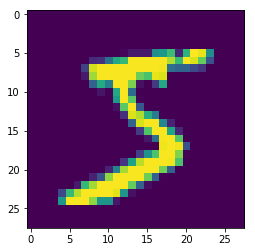

In [6]:
plt.imshow(MNIST_train[0][0].reshape(28,28))

(<matplotlib.image.AxesImage at 0x7f40567f2908>, 7)

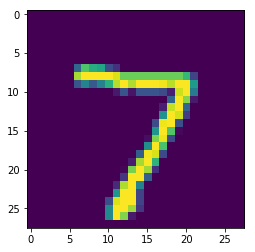

In [7]:
plt.imshow(MNIST_test[0][0].reshape(28,28)), MNIST_test[0][1]

In [8]:
 MNIST_train[0][1]

5

In [0]:
x = []
labels = []
for t, l in MNIST_train:
    x.append(t.numpy().flatten())
    labels.append(l)

In [0]:
x = np.array(x)
labels = np.array(labels)

In [70]:
x.shape

(60000, 784)

In [187]:
x_5 = None
l_5 = []
samples = 20
for n in range(5):
    d = x[np.where(labels == n)]
    idxs = np.random.choice(range(d.shape[0]), samples)

    print(d[idxs].shape)
    if x_5 is None:
        x_5 = d[idxs]
    else:
        x_5 = np.vstack((x_5, d[idxs]))
    l_5 = np.hstack((l_5,n* np.ones(samples)))

(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)


In [0]:
x_5 = np.array(x_5)

In [189]:
Y = x_5.astype(np.float64)
Y.shape

((100, 784),)

In [0]:
del x

In [191]:
Q = 5
M = 20
N = Y.shape[0]
X_mean = gpflow.models.PCA_reduce(Y, Q) 
Z = np.random.permutation(X_mean.copy())[:M]
kernel_dim = 5

k = kernels.RBF(kernel_dim, ARD=True, active_dims=slice(0,kernel_dim))
m = gpflow.models.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
                                kern=k, M=M, Z=Z)
m.likelihood.variance = 0.01

opt = gpflow.train.ScipyOptimizer()
m.compile()
opt.minimize(m, maxiter=gpflow.test_util.notebook_niter(500))
print("done")


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -9588.515662
  Number of iterations: 500
  Number of functions evaluations: 558


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -9588.515662
  Number of iterations: 500
  Number of functions evaluations: 558


done


In [20]:
m

,class,prior,transform,trainable,shape,fixed_shape,value
BayesianGPLVM/X_mean,Parameter,None,(none),True,"(250, 5)",True,"[[0.9124867585329028, 0.22397278396796602, -0...."
BayesianGPLVM/X_var,Parameter,None,+ve,True,"(250, 5)",True,"[[0.00459812196179218, 0.0033043951154245986, ..."
BayesianGPLVM/feature/Z,Parameter,None,(none),True,"(20, 5)",True,"[[-1.1645445276987754, -0.5671295518460037, -2..."
BayesianGPLVM/kern/lengthscales,Parameter,None,+ve,True,"(5,)",True,"[7.778473468886734, 4.507898992462784, 6.03707..."
BayesianGPLVM/kern/variance,Parameter,None,+ve,True,(),True,0.3827155007010727
BayesianGPLVM/likelihood/variance,Parameter,None,+ve,True,(),True,0.03078660519425074


In [21]:
m.kern.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
BayesianGPLVM/kern/lengthscales,Parameter,None,+ve,True,"(5,)",True,"[7.778473468886734, 4.507898992462784, 6.03707..."
BayesianGPLVM/kern/variance,Parameter,None,+ve,True,(),True,0.3827155007010727


In [22]:
kern = m.kern#.kernels[0]
sens = np.sqrt(kern.variance.read_value())/kern.lengthscales.read_value()
print(sens)

[0.07953232 0.13723467 0.10247339 0.17725701 0.22660198]


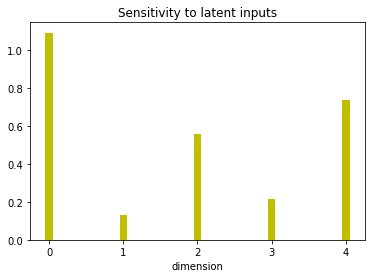

In [192]:
fig, ax = plt.subplots()
dims = np.arange(len(sens))
ax.bar(dims, sens, 0.1, color='y')
ax.set_xticks(dims)
ax.set_xlabel('dimension')
ax.set_title('Sensitivity to latent inputs');
plt.savefig('mnist_1l_sens.png')

In [0]:
dim1, dim2 = sens.argsort()[::-1][:2] 

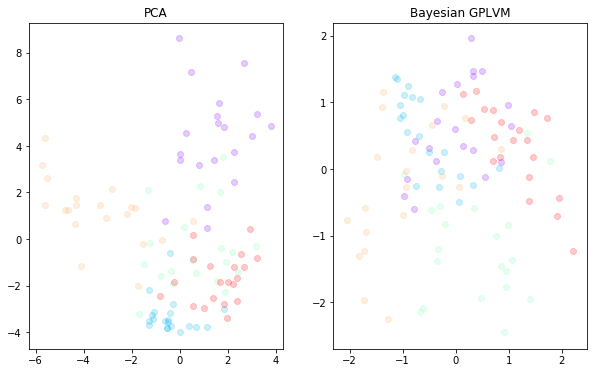

In [286]:
XPCAplot = gpflow.models.PCA_reduce(Y, 2)
GPLVM_X_mean = m.X_mean.read_value()

f, ax = plt.subplots(1,2, figsize=(10,6))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(l_5))))

for i, c in zip(np.unique(labels), colors):
    ax[0].scatter(XPCAplot[l_5==i, 0], XPCAplot[l_5==i, 1], color=c, label=i, alpha = 0.2)
    ax[0].set_title('PCA')
    ax[1].scatter(GPLVM_X_mean[l_5==i, dim1], GPLVM_X_mean[l_5==i, dim2], color=c, label=i, alpha = 0.2)
    ax[1].set_title('Bayesian GPLVM')
    f.savefig("mnist_1l_pca_rep.png")

17


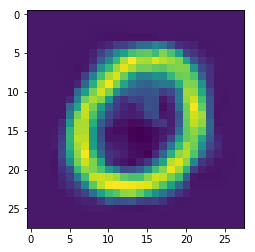

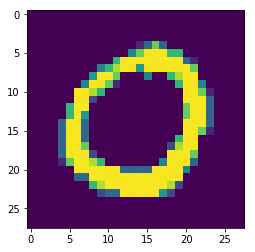

In [81]:
def reconstruct(Q, i):
    print(i)
    y = m.predict_y(GPLVM_X_mean[i].reshape(1,Q))[0]

    plt.imshow(y.reshape(28,28))
    plt.figure()
    plt.imshow(Y[i].reshape(28,28))

reconstruct(Q, i=np.random.randint(0,100))

### Deep Model  Implementation

In [200]:
dgp = DeepGPLVM(kernel_dims = [10,5], n_layers = 2, max_iters=300, latent_dims = [20, 5], inducing_pts=[20,20])
Y = x_5.astype(np.float64)
dgp.train(Y)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -12017.313656
  Number of iterations: 300
  Number of functions evaluations: 360


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -12017.313656
  Number of iterations: 300
  Number of functions evaluations: 360


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1786.611738
  Number of iterations: 300
  Number of functions evaluations: 326


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1786.611738
  Number of iterations: 300
  Number of functions evaluations: 326


[0.1476206  0.60075098 0.22371683 0.9156594  0.46505375]
[0.04653562 0.05395817 0.06020102 0.05785901 0.04311279 0.04554821
 0.13430964 0.04170134 0.03483984 0.0628714 ]


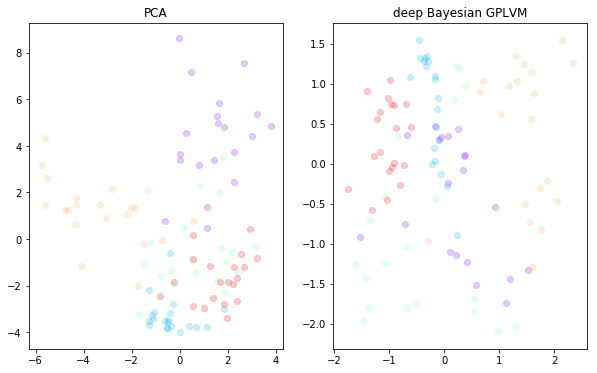

In [205]:
sens = dgp.get_sensitivities()[0]
dim1, dim2 = sens.argsort()[::-1][:2] 
XPCAplot = gpflow.models.PCA_reduce(Y, 2)
dgp_mean = dgp.means

f, ax = plt.subplots(1,2, figsize=(10,6))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(l_5))))

for i, c in zip(np.unique(labels), colors):
    ax[0].scatter(XPCAplot[l_5==i, 0], XPCAplot[l_5==i, 1], color=c, label=i, alpha = 0.2)
    ax[0].set_title('PCA')
    ax[1].scatter(dgp_mean[l_5==i, dim1], dgp_mean[l_5==i, dim2], color=c, label=i, alpha = 0.2)
    ax[1].set_title('deep Bayesian GPLVM')
    f.savefig("mnist_2l_pca_rep.png")

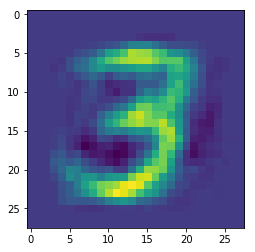

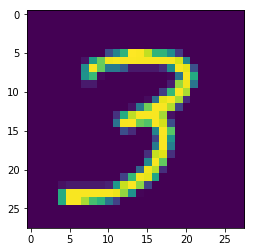

In [113]:
# GPLVM_X_mean = m.X_mean.read_value()
# recon = dgp.reconstruct(GPLVM_X_mean[6].reshape(1,Q))
i = np.random.randint(0,100)
recon = dgp.reconstruct(i)
plt.figure()
plt.imshow(recon.reshape(28,28))
plt.savefig("test1.png")
plt.figure()
plt.imshow(Y[i].reshape(28,28))

In [0]:
# from google.colab import files
# files.download("test.png")

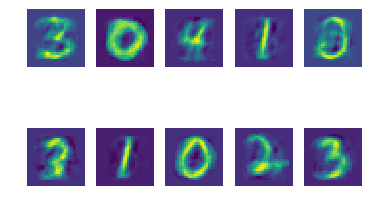

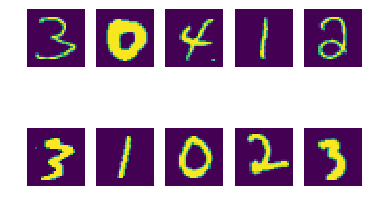

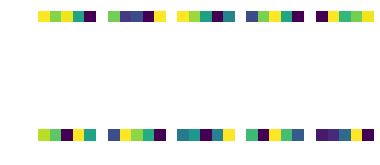

In [216]:
idxs = np.random.randint(0, Y.shape[0],10)#np.random.permutation(dgp.means)[:10]

# random_sample = dgp.means[idxs]

plt.figure()
for i, idx in enumerate(idxs,1):
#     rec= m.reconstruct(idx)
    rec = dgp.reconstruct(idx)
    plt.subplot(2,5,i)
#     print(rec.shape)
    plt.imshow(rec.flatten().reshape(28, 28))
    plt.axis("off")
plt.savefig("mnist_2l_recon.png")

plt.figure()
for i, y in enumerate(Y[idxs],1):
    plt.subplot(2,5,i)
    plt.axis("off")
    plt.imshow(y.flatten().reshape(28, 28))

plt.savefig("mnist_orig.png")
plt.figure()
for i, idx in enumerate(idxs, 1):
    plt.subplot(2,5,i)
    plt.axis("off")
    plt.imshow(dgp.means[idx].flatten().reshape(1,5))
plt.savefig("mnist_repn_2l.png")

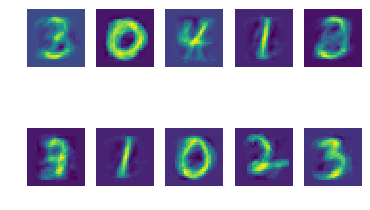

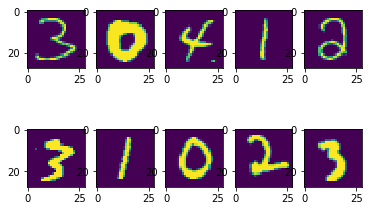

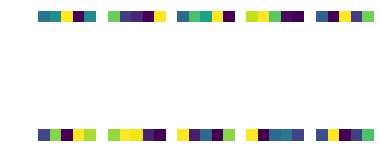

In [217]:
plt.figure()
for i, idx in enumerate(idxs,1):
    rec= m.predict_y(GPLVM_X_mean[idx].reshape(1,5))[0]
    plt.subplot(2,5,i)
    plt.axis("off")
    plt.imshow(rec.flatten().reshape(28, 28))
plt.savefig("mnist_1l_recon.png")
plt.figure()
for i, y in enumerate(Y[idxs],1):
    plt.subplot(2,5,i)
    plt.imshow(y.flatten().reshape(28, 28))

    
plt.figure()
for i, idx in enumerate(idxs, 1):
    plt.subplot(2,5,i)
    plt.axis("off")
    plt.imshow(GPLVM_X_mean[idx].flatten().reshape(1,5))
plt.savefig("mnist_repn_1l.png")

In [0]:
dgp.reconstructon_error(Y)

4.432431670278695

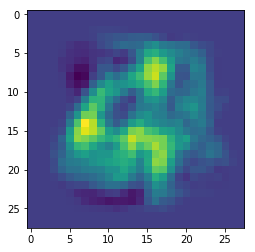

In [92]:
test = np.random.randn(dgp.latent_dims[-1]).reshape(1, dgp.latent_dims[-1])
# for model in reversed(dgp.models):
#     x_recon = model.predict_y(test)[0]
#     x_mean = x_recon
recon = dgp.reconstruct_from_input(test)
plt.imshow(recon.flatten().reshape(28,28))

[0.1476206  0.60075098 0.22371683 0.9156594  0.46505375]


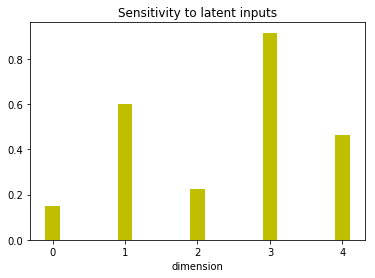

In [218]:
kern = dgp.models[1].kern#.kernels[0]
sens = np.sqrt(kern.variance.read_value())/kern.lengthscales.read_value()
print(sens)
fig, ax = plt.subplots()
dims = np.arange(len(sens))
ax.bar(dims, sens, 0.2, color='y')
ax.set_xticks(dims)
ax.set_xlabel('dimension')
ax.set_title('Sensitivity to latent inputs');
plt.savefig("mnist_2l_latent_sens.png")

In [0]:
# dgp.get_sensitivities(plot = True)

In [0]:
layers = [1, 2]
dim_list = [[[5], [10], [20]], [[10, 5], [10, 10], [20, 10]]]
inducing_pts = [[10, 20, 40], [[20, 20], [20, 10], [10, 10]]]


# frey faces

In [290]:
! wget "http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat" > frey.mat

--2019-04-26 08:32:51--  http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat
Resolving www.cs.nyu.edu (www.cs.nyu.edu)... 128.122.49.30
Connecting to www.cs.nyu.edu (www.cs.nyu.edu)|128.122.49.30|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.nyu.edu/~roweis/data/frey_rawface.mat [following]
--2019-04-26 08:32:51--  https://cs.nyu.edu/~roweis/data/frey_rawface.mat
Resolving cs.nyu.edu (cs.nyu.edu)... 128.122.49.30
Connecting to cs.nyu.edu (cs.nyu.edu)|128.122.49.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1100584 (1.0M) [text/plain]
Saving to: ‘frey_rawface.mat’

frey_rawface.mat    100%[===================>]   1.05M  --.-KB/s    in 0.1s    

2019-04-26 08:32:52 (9.97 MB/s) - ‘frey_rawface.mat’ saved [1100584/1100584]



In [0]:
! ls

data  frey.mat	frey_rawface.mat  sample_data  test1.png


In [291]:
from scipy import io as spio
data = spio.loadmat("frey_rawface.mat")
faces = data['ff'].T
faces = faces.astype(np.float32)/255
faces.shape

(1965, 560)

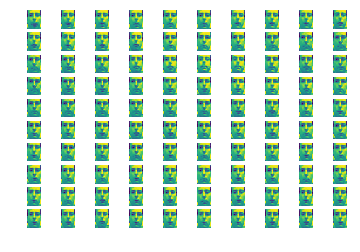

In [292]:
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.axis("off")
    plt.imshow(faces[i, :].reshape(28, 20))


In [0]:
idxs = np.random.randint(0, faces.shape[0], 200)
subset = faces[idxs, :]

In [294]:
dgp_f = DeepGPLVM(kernel_dims = [5, 3], n_layers = 2, max_iters=50, latent_dims = [10, 3], inducing_pts=[20, 20])
Y = subset.astype(np.float64)
dgp_f.train(Y)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -128926.151897
  Number of iterations: 50
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -128926.151897
  Number of iterations: 50
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 3382.210749
  Number of iterations: 50
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 3382.210749
  Number of iterations: 50
  Number of functions evaluations: 57


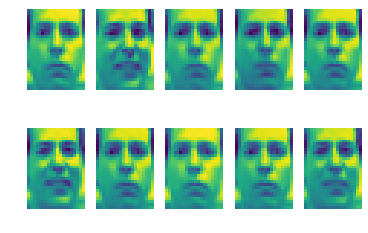

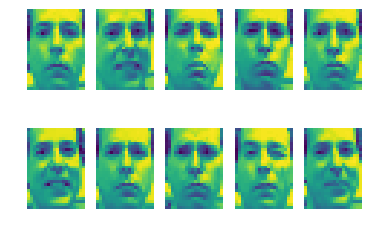

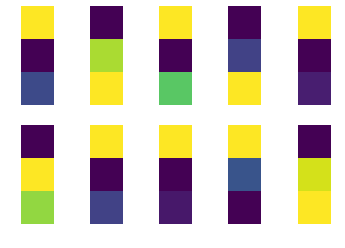

In [296]:
idxs = np.random.randint(0, Y.shape[0],10)#np.random.permutation(dgp.means)[:10]

# random_sample = dgp.means[idxs]

plt.figure()
for i, idx in enumerate(idxs,1):
#     rec= m.reconstruct(idx)
    rec = dgp_f.reconstruct(idx)
    plt.subplot(2,5,i)
#     print(rec.shape)
    plt.axis("off")
    plt.imshow(rec.flatten().reshape(28, 20))
plt.savefig("frey_recon_2l.png")

plt.figure()
for i, y in enumerate(Y[idxs],1):
    plt.subplot(2,5,i)
    plt.axis("off")
    plt.imshow(y.flatten().reshape(28, 20))
plt.savefig("frey_orig_2l.png")

    
plt.figure()
for i, idx in enumerate(idxs, 1):
    plt.subplot(2,5,i)
    plt.axis("off")
    plt.imshow(dgp_f.means[idx].flatten().reshape(3, 1))
plt.savefig("frey_2l_rep.png")

In [0]:
dgp_f.reconstructon_error(Y)

1.6707204412241508

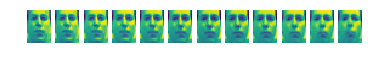

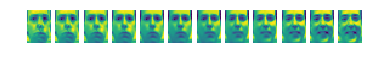

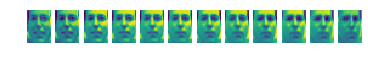

In [297]:
steps = np.arange(-3, 3, 0.5)
for i in range(3):
    plt.figure()
    for j, s in enumerate(steps):
        
        test = np.zeros((1,3))
        test[0][i] += s
        recon = dgp_f.reconstruct_from_input(test)
        plt.subplot(1, 12, j + 1 )
        plt.axis("off")
        plt.imshow(recon.reshape(28, 20))
        plt.savefig("frey_feature_{0}_trend_2l.png".format(i))

In [300]:
dgp_f3 = DeepGPLVM(kernel_dims = [5, 5, 3], n_layers = 3, max_iters=50, latent_dims = [10, 5, 3], inducing_pts=[20, 20, 20])
Y = subset.astype(np.float64)
dgp_f3.train(Y)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -128784.037425
  Number of iterations: 50
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -128784.037425
  Number of iterations: 50
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 2589.782168
  Number of iterations: 50
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 2589.782168
  Number of iterations: 50
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1690.256770
  Number of iterations: 50
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1690.256770
  Number of iterations: 50
  Number of functions evaluations: 57


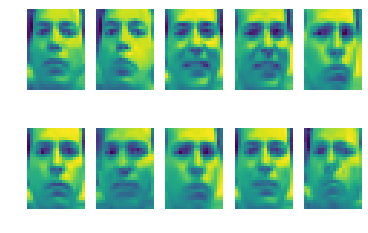

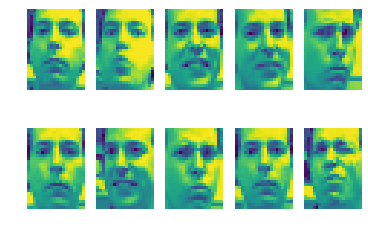

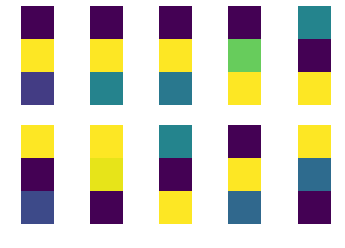

In [301]:
idxs = np.random.randint(0, Y.shape[0],10)#np.random.permutation(dgp.means)[:10]

# random_sample = dgp.means[idxs]

plt.figure()
for i, idx in enumerate(idxs,1):
#     rec= m.reconstruct(idx)
    rec = dgp_f.reconstruct(idx)
    plt.subplot(2,5,i)
#     print(rec.shape)
    plt.axis("off")
    plt.imshow(rec.flatten().reshape(28, 20))
plt.savefig("frey_3l_recon.png")
plt.figure()
for i, y in enumerate(Y[idxs],1):
    plt.subplot(2,5,i)
    plt.axis("off")
    plt.imshow(y.flatten().reshape(28, 20))

plt.savefig("frey_orig_3l.png")
plt.figure()
for i, idx in enumerate(idxs, 1):
    plt.subplot(2,5,i)
    plt.axis("off")
    plt.imshow(dgp_f.means[idx].flatten().reshape(3, 1))
plt.savefig("frey_3l_rep.png")

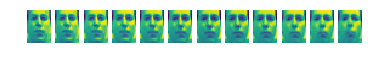

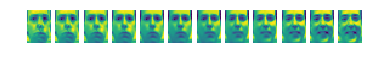

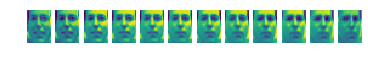

In [302]:
steps = np.arange(-3, 3, 0.5)
for i in range(3):
    plt.figure()
    for j, s in enumerate(steps):
        
        test = np.zeros((1,3))
        test[0][i] += s
        recon = dgp_f.reconstruct_from_input(test)
        plt.subplot(1, 12, j + 1 )
        plt.axis("off")
        plt.imshow(recon.reshape(28, 20))
        plt.savefig("frey_feature_{0}_trend_3l.png".format(i))
        

In [0]:
dgp2 = DeepGPLVM(kernel_dims = [10,5], n_layers = 2, max_iters=100, latent_dims = [10, 5], inducing_pts=[20, 20])
Y = subset.astype(np.float64)
dgp2.train(Y)
dgp2.reconstructon_error(Y)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -150863.756356
  Number of iterations: 100
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -150863.756356
  Number of iterations: 100
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 3786.634038
  Number of iterations: 100
  Number of functions evaluations: 108


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 3786.634038
  Number of iterations: 100
  Number of functions evaluations: 108


1.64509931828917

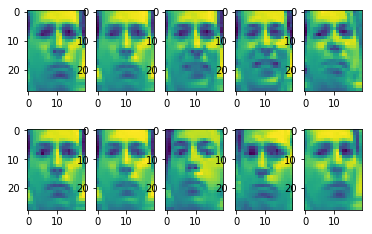

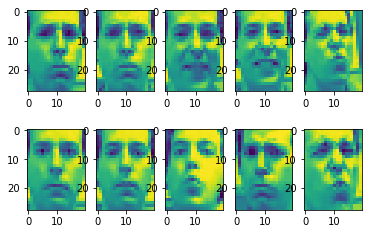

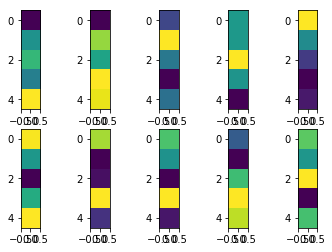

In [0]:
# random_sample = dgp.means[idxs]

plt.figure()
for i, idx in enumerate(idxs,1):
#     rec= m.reconstruct(idx)
    rec = dgp2.reconstruct(idx)
    plt.subplot(2,5,i)
#     print(rec.shape)
    plt.imshow(rec.flatten().reshape(28, 20))

plt.figure()
for i, y in enumerate(Y[idxs],1):
    plt.subplot(2,5,i)
    plt.imshow(y.flatten().reshape(28, 20))

    
plt.figure()
for i, idx in enumerate(idxs, 1):
    plt.subplot(2,5,i)
    plt.imshow(dgp2.means[idx].flatten().reshape(5, 1))

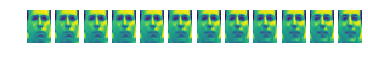

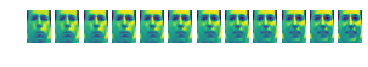

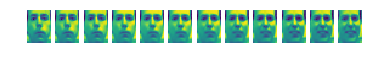

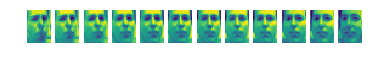

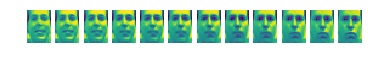

In [0]:
steps = np.arange(-3, 3, 0.5)
for i in range(5):
    plt.figure()
    for j, s in enumerate(steps):
        
        test = np.zeros((1,5))
        test[0][i] += s
        recon = dgp2.reconstruct_from_input(test)
        plt.subplot(1, 12, j + 1 )
        plt.axis("off")
        plt.imshow(recon.reshape(28, 20))

### Downstream classification accuracy comparison (MNIST)

In [259]:
XPCA = gpflow.models.PCA_reduce(Y, 5)
results = []
for i in tqdm(range(500)):
    trn_idxs, test_idxs = get_idxs(x_5.shape[0])
    a1 = classifier_on_data(x_5, l_5, trn_idxs, test_idxs)
    a2 = classifier_on_data(XPCA, l_5, trn_idxs, test_idxs)
    a3 = classifier_on_data(GPLVM_X_mean, l_5, trn_idxs, test_idxs)
    a4 = classifier_on_data(dgp.means, l_5, trn_idxs, test_idxs)
    
    results.append([a1, a2, a3, a4])

results = np.array(results)

100%|██████████| 500/500 [00:08<00:00, 57.76it/s]


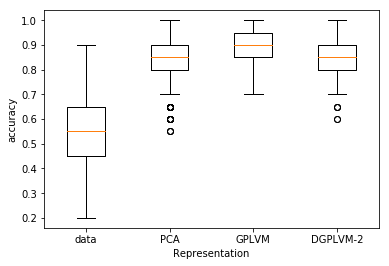

In [260]:
_ = plt.boxplot(results[:, :])
plt.xticks([1,2,3, 4], ['data', 'PCA', 'GPLVM', 'DGPLVM-2'])
plt.xlabel('Representation')
plt.ylabel('accuracy')
plt.savefig("boxplot_mnist.png")

### Classification accuracy on oil flow dataset

In [4]:
dgp_oil = DeepGPLVM(kernel_dims = [10,5], n_layers = 2, max_iters=2000, latent_dims = [10, 5], inducing_pts=[20,20])
dgp_oil.train(Y)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -5737.550938
  Number of iterations: 2000
  Number of functions evaluations: 2107


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -5737.550938
  Number of iterations: 2000
  Number of functions evaluations: 2107


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -10874.413170
  Number of iterations: 174
  Number of functions evaluations: 232


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -10874.413170
  Number of iterations: 174
  Number of functions evaluations: 232


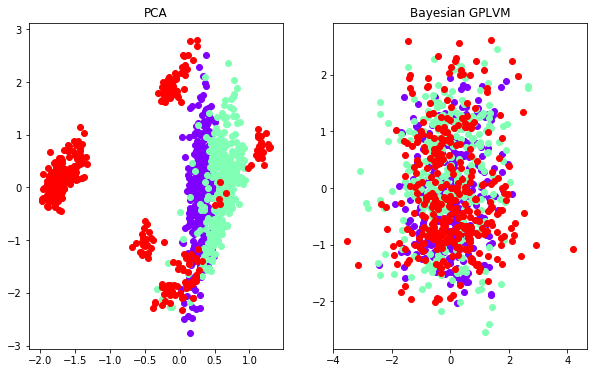

In [29]:
XPCAplot = gpflow.models.PCA_reduce(Y, 2)
GPLVM_X_mean = m.X_mean.read_value()

f, ax = plt.subplots(1,2, figsize=(10,6))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))

for i, c in zip(np.unique(labels), colors):
    ax[0].scatter(XPCAplot[labels==i, 0], XPCAplot[labels==i, 1], color=c, label=i)
    ax[0].set_title('PCA')
    ax[1].scatter(dgp_oil.means[labels==i, dim1], dgp_oil.means[labels==i, dim2], color=c, label=i)
    ax[1].set_title('Bayesian GPLVM')
plt.savefig("oil_pca_rep_2l.png")

In [42]:
XPCA = gpflow.models.PCA_reduce(Y, 5)
from tqdm import tqdm
results = []
labels = np.array(labels)
for i in tqdm(range(100)):
    trn_idxs, test_idxs = get_idxs(Y.shape[0])
    a1 = classifier_on_data(Y, labels, trn_idxs, test_idxs)
    a2 = classifier_on_data(XPCA, labels, trn_idxs, test_idxs)
    a3 = classifier_on_data(GPLVM_X_mean, labels, trn_idxs, test_idxs)
    a4 = classifier_on_data(dgp_oil.means, labels, trn_idxs, test_idxs)
    
    results.append([a1, a2, a3, a4])

results = np.array(results)

100%|██████████| 100/100 [00:05<00:00, 17.15it/s]


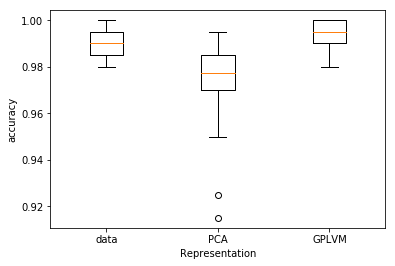

In [43]:
_ = plt.boxplot(results[:, :-1])
plt.xticks([1,2,3], ['data', 'PCA', 'GPLVM'])
plt.xlabel('Representation')
plt.ylabel('accuracy')
plt.savefig("boxplot_oil.png")